In [0]:
#imports
!pip install censusgeocode
import pandas as pd
import censusgeocode as cg
!pip install folium --upgrade
from folium.plugins import HeatMap
import folium as folium
import numpy as np

     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 61kB 22.9MB/s 
     |████████████████████████████████| 2.3MB 8.3MB/s 
     |████████████████████████████████| 102kB 29.2MB/s 
Requirement already up-to-date: folium in /usr/local/lib/python3.6/dist-packages (0.8.3)


**Research Question**
Can you predict life expectancy based on proximity to factories and carcinogen exposure? Our project will utilize datasets that provide not only geographical data, but also data describing factories and the emissions they release. To make our data more manageable, we will only look at factories in California and Life Expectancy predictions from 2010. We hope to see in what ways proximity to factories and the amount of toxins released influence life expectancy by census tract.



**Why the Question is Important**
We came up with this question after thinking a lot about what our group found most passionate as a collective team. We all felt a strong passion for public policy and for using the tools we have learned in this class to give our best effort in researching a question that may actually have some real-life application. With all of us growing up in the Los Angeles area, we realized that our proximity to factories was very close. We knew that the chemicals being exposed were probably going to have some effect on the community and the greater Los Angeles area so we thought that an appropriate and applicable question to consider would be if we could predict someone’s life expectancy based on their exposure to chemicals and their proximity to factories. Through this notebook, you will be able to explore our methods of choice and how we came to reach our conclusions. With the help of Professor Marshall and his expertise on Environmental Protection Agency data, we were able to find the necessary data needed to make our analysis. While we hope to answer our question as best as possible, we recognize that regardless of our conclusions this question and project will be a step towards exploring the effects of industrial pollution and a place for future researchers to begin with and to explore their own questions regarding the environment and public policy issues. 


**Finding the Data**
We will use data from the EPA Toxins Release Inventory to get locations of factories and characteristics of the pollutants emitted from these plants. We will be looking at TRI data from California from 2010. We intend to use the CDC Life Expectancy project data to get data on life expectancy by census tract. We will use Life Expectancy data for California for 2010 to match it to the time and area frame of the Factory data. Narrowing our data to these areas and years will make our dataset smaller and more manageable. We chose to use 2010 because that is the last year the Census was taken. We chose California because we are all from California and have the most regional knowledge of this area. Professor Marshall recommended we use the EPA Toxins Release Inventory dataset. We found the CDC Life Expectancy Project through online research. Both datasets are publicly sourced and intended for public use.


**Assembling the Data** 
We needed to combine the EPA dataset with the CDC dataset. We were able to do this using the Census GeoCoder API. The Census Geocoder API matched the EPA dataset to the CDC dataset by census tract ID. The Census GeoCoder was computationally expensive and took 14 hours to process all of our data for California for 2010. After we processed all of our data, we saved the new table as a CSV to save time. 
Before we combined the datasets, we went through both datasets to select relevant features to include. We kept the features Factories, Chemicals, Carcinogen, On-Site Release Total, and Total Release Total from the EPA Toxins Release Inventory Dataset. We selected these features after manually going through the EPA Codebook and selecting the features we thought would be the most relevant. We acknowledge that there might be errors in this kind of selection, but given the large number of bureaucratic features such as Standard Industrial Classification Code, North American Standard Industry Classification System Code, and others like this, we think manual selection was a good strategy for choosing relevant features. We kept most of the features in the CDC data because that dataset had fewer features. We are primarily looking at the “e(0)” feature, which is the life expectancy for someone in that census tract in 2010.


In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
plants = pd.read_csv('TRI_2010_CA.csv')# Data on the factory plants in CA, their lat/lon cordinates and the data on the chemicals they release and at what quantities.
le = pd.read_csv('CA_A.csv')#Life expectency data based on census tract ID

FileNotFoundError: ignored

In [0]:
#This function converts a longitude and latitude to a census tract ID
def findTract(long,lat):
    return(cg.coordinates(float(long),float(lat))['2010 Census Blocks']) 


#This is the average life exectency of CA. We will use this to compare between regions of California. 
avg = le["e(0)"].sum()/len(le) 
avg

80.23101383714743

In [0]:
# PLEASE NOTE THAT THE CELL BELOW LOADS THE DATASET WE GOT FROM THIS CELL. IT WILL SAVE YOU MANY HOURS.

# Goal #1 - Organize the data. This entails combining both the life expectency data based on census tract with the data on 
# factories into one single dataset. 

df = le.copy() #First, make a copy of the life expectency data set. This is our base dataset we will use to build from. 
df["Factories"] = 0 #Add a new factories column to begin counting how many factories are in each census tract location. 
df["Chemicals"] = " "
df["Carcinogen"] = " "
df["On-Site_Release_Total"]=0.0
df["Total_Release"]=0.0

# !!!IMPORTANT!!! FOR EVERY PLANT WE SEEK TO RECIEVE DATA FROM, WE MUST PLACE ITS LON AND LAT INTO A CENSUS TRACT ID. 
# THIS IS WHAT THE CENSUS GEO CODE RESOURCE IS USED FOR. 
# CENSUSGEOCODE IS A VERY COMPUTATIONALLY TAXING RESOURCE BEGINS IT REQUIRES A NEW HTTPS CONNECTION FOR EVERY ASSESSMENT. 
# IT TAKES MY COMPUTER SEVERAL SECONDS TO PLACE ONE PAIR OF CORDINATES INTO A CENSUS TRACT SO I WORK WITH A SAMPLE. ALSO, 
# IF THERE IS THE SLIGHTEST MISHAP IN THE CONNECTION, THE LOOP WILL STOP IN EITHER A CONNECTION ERROR OR INTERPRETATION ERROR
# SOURCED IN THE findTract FUNCTION. 
# HOWEVER, I HAVE WRITTEN THE FUNCTION IN A WAY THAT SHOULD ALLOW FOR THE ENTIRE FACTORY PLANT DATA SET TO BE CONVERTED 
# WITHIN A CENSUS TRACT LOCATION BUT IT WILL TAKE SEVERAL HOURS TO DO SO. 

# Please set a sample size that your computer can handle to demonstrate the model. 
plantssample = plants.sample(100)
count=0

for index, row in plantssample.iterrows():
    try:
        ft = findTract(plantssample.loc[index,'LONGITUDE'],plantssample.loc[index,'LATITUDE'])[0]#Function that converts
        # longitude and latitude into a census tract location. 
        t = int(ft["GEOID"][1:11])# this converts the geoid into a census tract ID
        for i in df["Tract ID"]:# this loops through the census tract ID in our base life expectency dataset. 
            if(int(i)==int(t)):#This conditional matches t(census tract ID of the plant) to i(the census tract ID of our base life expectency dataset)
                # if these two are equal than we have a match and we then want to take the data from our factory dataset and 
                # place it in our base life expectency dataset under the same census tract ID of course. 
                
                # We have chosen several most important variables of the data of the specific factory to add to our base life
                # expectency dataset. Such as the list of chemicals released, carcinogens, and the pollutant release totals
                
                # I also add Latitude and Longitutde of the center point of the census tract area for mapping purposes
                # that'll be utilized later on. 
                df.loc[df['Tract ID'] == i,"Factories"] =  int(df.loc[df['Tract ID'] == i,"Factories"]) + 1
                df.loc[df['Tract ID'] == i,"Chemicals"] = df.loc[df['Tract ID'] == i,"Chemicals"]+ " " +plantssample.loc[index,"CHEMICAL"]+","
                if(str(df.loc[df['Tract ID'] == i,"Carcinogen"]) != "YES"):
                    df.loc[df['Tract ID'] == i,"Carcinogen"] = plantssample.loc[index,"CARCINOGEN"]
                df.loc[df['Tract ID'] == i,"On-Site_Release_Total"] = df.loc[df['Tract ID'] == i,"On-Site_Release_Total"]+plantssample.loc[index,"ON-SITE_RELEASE_TOTAL"]
                df.loc[df['Tract ID'] == i,"Total_Release"] = df.loc[df['Tract ID'] == i,"Total_Release"]+plantssample.loc[index,"TOTAL_RELEASES"]
                df.loc[df['Tract ID'] == i,"Latitude"] = str(ft['CENT']).split(", ")[1][:-1]
                df.loc[df['Tract ID'] == i,"Longitude"] = str(ft['CENT']).split(", ")[0][1:]
                factnumb= int(df.loc[df['Tract ID'] == i,"Factories"]) 
                df.loc[df['Tract ID'] == i,"Factory_"+str(factnumb)+"_lat"] = plantssample.loc[index,"LATITUDE"]
                df.loc[df['Tract ID'] == i,"Factory_"+str(factnumb)+"_lon"] = plantssample.loc[index,"LONGITUDE"]
                break #We matched our census tracts so no need to continue the loop. 
        #count=count+1
        #if count%100 == 0:
            #df.to_csv("lifeexpectencyandfactorychemicaldata.csv")
            #print(count)
            
    except: 
        print("There was an error in the http request made by the census geocode resource. This could be a minor issue with the connection at the time. Don't worry. loop will continue to run.")


There was an error in the http request made by the census geocode resource. This could be a minor issue with the connection at the time. Don't worry. loop will continue to run.
There was an error in the http request made by the census geocode resource. This could be a minor issue with the connection at the time. Don't worry. loop will continue to run.
There was an error in the http request made by the census geocode resource. This could be a minor issue with the connection at the time. Don't worry. loop will continue to run.


In [0]:
# THIS IS THE CSV OF THE DATA WE LOADED FROM THE CELL ABOVE
df = pd.read_csv('lifeexpectencyandfactorychemicaldata.csv')

**Visualization of Data**
To visualize the data, we chose to modify a heatmap to both be able to plot locations of census tracts that contained a factory, along with life expectancy within that census tract.  To do this, we created a couple indicators that utilize the standard utilities of the heatmap while also portraying what we ultimately wanted to portray. First, to indicate where the census tract locations where, we used a white dot to mark the center coordinates of each census tract.  We did this because the white dots provide a visual point that can easily be seen even when the heat from the heatmap is spread out.  There were ideas of using the white dots to plot the locations of all the factories in CA, however there were too many factories and the heatmap software could not handle such a large degree of dots on one map.  The next goal was to map life expectancy on the heatmap.  To do this, we needed to modify the functions of the heatmap to provide a single point on the center location of the census tract and modify its intensity dependent on the life expectancy of the census tract.  We used the insert() heatmap function to accomplish this.  In the end, a census tract with a purple hue marked a census tract with a life expectancy near the maximum life expectancy of California which is around 91. A blue hue marked a life expectancy that was at least 2 years above the average life expectancy of California which is 79. A green hue means that the average life expectancy of that census tract was plus or minus 2 years around the average life expectancy of California. A yellow hue signifies that the life expectancy is at least two years less than the average life expectancy of California. And a red hue signifies a census tract life expectancy two years around the minimum life expectancy of California which is 69.  The finishing product results in a map of California with white dots marking the center locations of census tracts with factories in them, along with a color using heatmap functions to visualize what the average life expectancy is of that census tract. 


In [0]:
# Goal #2 is to map our data in a way that is understandable for viewers. 

# This is done by creating a folium map of the great state of California. 
mymap = folium.Map([36.7783, -119.4179], zoom_start=6)
# We then make an array of the non null values in both the lon and lat of our base dataset. These locations are the centers 
# of census tract locations that have at least one factory in said area. Important to note that these arrays will varry in 
# size depending on how large or small you set your sample of factory plants to be. 
lat = df["Latitude"].dropna().values
lon = df["Longitude"].dropna().values

# Convert contents of arrays to floats. It'll throw you an error if they're any other type. 
lat = np.array(lat, dtype=float)
lon = np.array(lon, dtype=float)

# Stacks our arrays into a list. 
call_locs = np.vstack((lat, lon)).transpose().tolist() 
i=0
# !!!IMPORTANT EXPLANATION!!!
# I am now going to explain what this loop does and how it relates to the specifics of the visualization of the heatmap. 
# The heatmap maps life expectency in California by looping through the locations of factories in our dataset, and adjusts
# the temperature of the colors of the heatmap based on the census tract's life expectency based on the state average. 
# For instance, locations well below the average life expectency and the near the lowest rates in the state will be a red. 
# Locations below the average will be a yellow. Locations that are near the average will be a green. Locations above the 
# average will be a blue. Locations in purple are well above the state life expectency average and near the max. 
# THe white dot simply signifies the center point of the census tract location. 

# THe heatmap adjusts its temperature based on its surrouding temperatures so you must zoom in for the most accurate view of
# the colors. 
while i<len(call_locs):
    #print(df.loc[df["Latitude"]==call_locs[i][0]].loc[df["Longitude"]==call_locs[i][1]])
    d = df.loc[df["Latitude"]==str(call_locs[i][0])].loc[df["Longitude"]==str(call_locs[i][1])]
    #print(float(d['e(0)']))
    lifespan = float(d['e(0)'])
    dens=0 
    if lifespan-avg >=13:#purple = well above state average life expectency
        dens=2000
    elif lifespan-avg >=8:#blue = above state average life expectency
        dens = 2700
    elif lifespan-avg >=-3:#green = around the average of state life expectency
        dens = 3200
    elif lifespan-avg >=-5:#yellow = below the state average state life expectency
        dens = 4000
    elif lifespan-avg >=-13:#red = well velow the state average life expectency
        dens=5000
        
    call_locs[i].insert(3,dens)
    i=i+1
    #print(dens)

#5000 = red 3800 = yellow 3200 = green 2700=blue 2000=purple
heatmap = HeatMap(call_locs, radius = 17,max_val=1, min_opacity = 0.1,max_zoom=50) 
mymap.add_child(heatmap)
for i in call_locs:
    folium.CircleMarker( location=[ i[0],  i[1] ],radius=1,axis=1,color="white").add_to(mymap)
    

mymap

In [0]:
d =df.loc[df["Factories"] >0] #make another dataset from the main dataset(df) that has factory information, removes the 
# subjects outside of the sample. 
d


,Unnamed: 0,Tract ID,STATE2KX,CNTY2KX,TRACT2KX,e(0),se(e(0)),Abridged life table flag,Factories,Chemicals,...,Factory_44_lat,Factory_44_lon,Factory_45_lat,Factory_45_lon,Factory_46_lat,Factory_46_lon,Factory_47_lat,Factory_47_lon,Factory_48_lat,Factory_48_lon
59,59,6001406100,6,1,406100,76.2,1.4586,3,3,"COPPER, LEAD, LEAD COMPOUNDS,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,74,6001407300,6,1,407300,73.9,2.1253,3,2,"AMMONIA, STYRENE,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,90,6001408900,6,1,408900,74.2,2.5196,1,3,"ZINC COMPOUNDS, LEAD COMPOUNDS, MANGANESE CO...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,121,6001422000,6,1,422000,79.9,2.0167,2,8,"LEAD, NAPHTHALENE, PHENOL, NICKEL, MANGANESE...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,143,6001425104,6,1,425104,80.0,1.3671,2,1,"SEC-BUTYL ALCOHOL,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,147,6001427300,6,1,427300,78.0,1.2697,1,1,"ACETONITRILE,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,177,6001432400,6,1,432400,80.6,1.6033,3,10,"NICKEL, DIISOCYANATES, COBALT, CHROMIUM, TOL...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,220,6001437101,6,1,437101,81.4,1.7513,3,27,"BUTYL ACRYLATE, ACRYLONITRILE, ACRYLIC ACID,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,233,6001438203,6,1,438203,78.1,2.3764,3,2,"MERCURY, AMMONIA,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,239,6001440301,6,1,440301,82.4,2.4056,3,6,"MANGANESE COMPOUNDS, LEAD COMPOUNDS, BARIUM ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#There are significantly more factories in census tract locations where the life expectency is less than the average
# and less factories where the life expectency is greater than the average. 

# This begs the question that asks what characteristics of factories are the greatest determining factors on life expectency.
print(sum(d.loc[df["e(0)"]<avg,'Factories']),sum(d.loc[df["e(0)"]>avg,'Factories']))

1709 1085


# Models (Modeling Choices, Results, and Explanations)

**Regression Models: **

Ridge Regression:
We are choosing ridge regression because we think it will model certain features in our data well. We expect to find linear relationships between features like “Carcinogenic,” “Release Total” and life expectancy and we believe ridge regression will be a good technique to model these relationships. Ridge adds a degree of bias to the regression estimates to reduce standard errors and avoid overfitting. Our data might be suffering from multicollinearity (i.e. independent variables are correlated) and we hope ridge regression will catch this multicollinearity and penalize it. 


Linear Regression:
We are choosing linear regression because we think it will model certain features in our data well. We expect to find linear relationships between features like “Carcinogenic,” “Release Total” and life expectancy and we believe linear regression will be a good technique to model these relationships. 

Elastic Net Regression:
We chose Elastic Net Regression as we considered the downfalls of using LASSO regression. LASSO suffers from issues in terms of its feature selection techniques. Some of these issues involve LASSO only choosing one feature from a group of correlated features. In addition, LASSO’s choosing of features is inconsistent and can be unstable due to its heavy dependency on the data. Considering the strengths and weaknesses of different machine learning models, we eventually chose to use Elastic Net as our final model. This is because this type of regression is a sort of combination of Ridge and Lasso Regression. Elastic Net utilizes distinct penalties from Ridge and LASSO that are often very helpful. LASSO regression shrinks less important features to zero, thus removing the feature entirely while Ridge regression adds a penalty to the features but does not remove them entirely. However, Elastic Net regression retains certain key techniques of Ridge such as Ridge’s regularization properties. 
We found Elastic Net applicable and potentially helpful because we believe many of our features have correlation with one another. Elastic Net is therefore useful since instead of doing LASSO techniques (such as picking randomly only one feature that showed correlation instead of all), Elastic Net chooses all the correlated features, relieving potential bias-variance tradeoff issues of overfitting and underfitting the data. In our dataset, we think there are features that are correlated and we would like to consider all of them, not eliminating any of them. For example, we expect there to be a negative correlation between “total release of pollutants” and “life expectancy.” As more pollutants are exposed to the environment, we believe that this would cause numerous health effects that would lower life expectancy of people in that respective area/community. 

LASSO Regression: 

We also ran LASSO regression as an extra regression model to see what would happen. As stated above, Elastic Net was a better alternative in our opinion based on our data and the applications of Elastic Net but we felt it could still be noteworthy to have LASSO used. 


**Data Cleaning: **

 We cleaned the data when we combined the TRI and CDC Life Expectancy datasets. There were many features we could have chosen from, so we chose the ones we thought that would make the most sense in modeling life expectancy. The features we chose were: Tract ID, State, County, Tract, Life Expectancy, Standard Error of Life Expectancy, Abridged Life Table Flag, Number of Factories, Chemicals, Carcinogens, On-site release total, total release, latitude, and longitude. Many of the features we could have used seemed bureaucratic and useless, so we picked the features we felt most relevant. We did not think we had to use a feature selection method in order to get the best features. This may be one of the luxuries and positive aspects of the data we chose. 



In [0]:
#Imports for models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [0]:
mdata = d.copy()


X = mdata[["Total_Release","Factories"]]#,"Factories","On-Site_Release_Total"
y = mdata['e(0)']

#Train/Test set
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.80, test_size=0.20)
#Train/Validation set 
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,train_size=0.80, test_size=0.20)

dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)
print("Validation Score: "+ str(dtr.score(X_validate, y_validate)))
print("Test Score: "+str(dtr.score(X_test,y_test)))

#rmse function to calculate the mean squared error between predicted and actual values. 
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))


Validation Score: -0.4291483976694781
Test Score: -1.0068073594379223


## Linear Regression

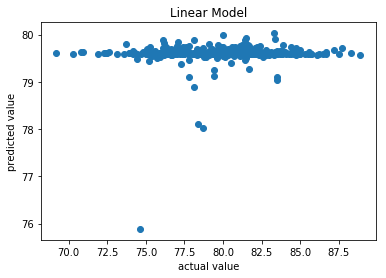

In [0]:
lin_reg = LinearRegression(normalize=True)
lin_model = lin_reg.fit(X_train, y_train)
lin_pred = lin_model.predict(X_train)

plt.scatter(y_train, lin_pred)
plt.title('Linear Model')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

## Ridge Regression

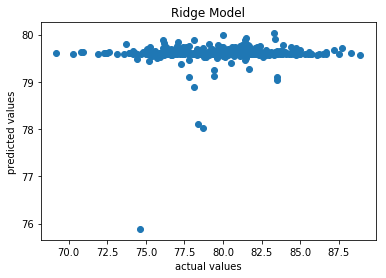

In [0]:
ridge_reg = Ridge() 
ridge_model = ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_train)

plt.scatter(y_train, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

## Elastic Net

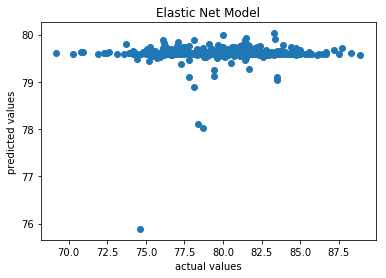

In [0]:
enet_reg = ElasticNet(random_state=0)
enet_model = enet_reg.fit(X_train, y_train)
enet_pred = enet_model.predict(X_train)

plt.scatter(y_train, ridge_pred)
plt.title('Elastic Net Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

## Lasso Regression

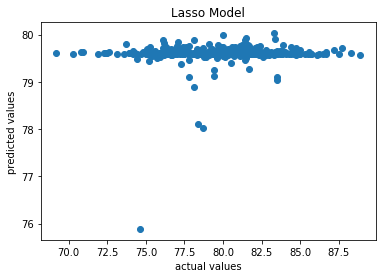

In [0]:
lasso_reg = Lasso()
lasso_model = lasso_reg.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_train)

plt.scatter(y_train, ridge_pred)
plt.title('Lasso Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

## Testing the Model

In [0]:
lin_vpred = lin_model.predict(X_validate)
ridge_vpred = ridge_model.predict(X_validate)
enet_vpred = enet_model.predict(X_validate)
lasso_vpred = lasso_model.predict(X_validate)
print("linear model rmse: ", rmse(lin_vpred, y_validate))
print("Ridge rmse: ", rmse(ridge_vpred, y_validate))
print("Elastic Net rmse: ", rmse(enet_vpred, y_validate))
print("Lasso rmse: ", rmse(lasso_vpred, y_validate))

linear model rmse:  3.4215453849191153
Ridge rmse:  3.4215444807552835
Elastic Net rmse:  3.410143946792179
Lasso rmse:  3.4101441406065183


In [0]:
from sklearn.metrics import r2_score
final_pred = ridge_model.predict(X_test)

print('Test set rmse: ', rmse(final_pred, y_test))

print("Test Set R Squared Score",r2_score(final_pred,y_test) )

Test set rmse:  3.61759013512752
Test Set R Squared Score -5.094056160306792


### Cross Validation

In [0]:
ridge_predicted = cross_val_predict(ridge_reg, X, y, cv = 3)
r2_score(y, ridge_predicted)

-0.0025485591058183044

# Model and Validation Explanation 

    We ran several different regression models which all contain certain benefits. Despite all of these different modeling methods, the results were all comparable. We have a low RMSE score on all of our models and a varrying r squared. We attribute these results to the mass amount of data that have factories in census tracts around the average life expectency of California which is 79. Our RMSE values are so low because our model is overfitted to our data. Typically, low RMSE would be a sign that our model is correctly fitted to our data. However, this would be a case of overfitting a model. It realies too much on the average life expectency. However, our model has little predictive power due to its overfitting nature. The model is making future predictions predominantly on the average life expectency but it is not accounting enough for outliers.  To validate our model we looked at the RMSE of all of our trained models. We then selected our ridge model to run a cross validation test. However, while our RMSE scores were low, our r squared values were unfortunately too low. The r squared in our cross validation hints to a lack of power when it comes to the predictive capabilities of our model. 

In [0]:
#The mean and the median of the total released toxins from factories by census tract. 
print("Mean of the total released toxins: ",np.mean(d['Total_Release']))
print("Median of the total released toxins: ",np.median(d['Total_Release']))

NameError: ignored

In [0]:
# The data of the outliers within five years of the min life expectency
d.loc[d["e(0)"]<=min(d['e(0)']+5)]

In [0]:
# The total releases of the outliers within fice years of the min
print("Mean of the outliers near the min life expectency: ",np.mean(d.loc[d["e(0)"]<=min(d['e(0)']+5)].loc[:,"Total_Release"]))
print("Median of the outliers near the min life expectency:", np.median(d.loc[d["e(0)"]<=min(d['e(0)']+5)].loc[:,"Total_Release"]))

In [0]:
# The data of outliers within five years of the max life expectency. 
d.loc[d["e(0)"]>=max(d['e(0)']-5)]

In [0]:
# The mean and the median for the total released toxins from the total released 
print("Mean of outliers near the max life expectency: ",np.mean(d.loc[d["e(0)"]>=max(d['e(0)']-5)].loc[:,"Total_Release"]))
print("Median of the outliers near the max life expectency:", np.median(d.loc[d["e(0)"]<=max(d['e(0)']-5)].loc[:,"Total_Release"]))

**Conclusions**
Unfortunately, there is not much we can conclude about our hypothesis. We did not find a relationship between proximity to factories and life expectancy. There are too many census tracts with factories that also have an average life expectancy and too few outliers to find a relationship between life expectancy and proximity to toxins. We need more outliers to make stronger conclusions because too much of our data is centered around the mean. 
Some possible gaps include grouping by census tract, not enough data, and mistakes in our treatment and control group. We grouped by census tract because that was the smallest unit of analysis we could code by. Moreover, we figured (correctly) that most census tracts would only have one or two factories. Grouping by census tract, however, would help us observe the impact of individual factories on their surrounding communities. However, we might have seen stronger results grouping by larger units, such as zip code or county. Some issues with that kind of grouping, however, include size and number of factories from zip code to county. For example, Los Angeles County is very large and has many factories in some areas and almost none in others. Grouping by County or Zip Code might produce better results, but on a scope that won’t always show the effects of proximity.  
Another issue is the lack of data, given that we only considered factory data from 2010. We were limited by the strength of our computers on this front — it took 14 hours to combine the data by census tract for just California for 2010. Perhaps researchers with stronger equipment could conduct this experiment on a larger scale and get better results.
Another issue is that we compared census tracts with factories against other census tracts with factories as opposed to census tracts with factories against census tracts without factories. Another researcher might compare census tracts with factories (treatment) against census tracts without factories (control). This method of analysis would make a stronger experiment. We did not attempt this in our analysis because it posed many methodological challenges. There would be too much data to consider and process. Furthermore, life expectancy will still vary across census tracts and accounting for these differences would have been challenging. It would still be hard to make a comparison in this way — given the geographical nature of our project — but it would definitely be worth attempting if other researchers wanted to attempt our project.


**How Well Methods Served our Goals/ What might we do differently?**
We believe our choice of data using the Toxics Release Inventory Data, the Life Expectancy data, and the US Census geocode API were all good choices for our goal in trying to predict whether we can predict life expectancy. We were able to properly combine the data together to create one dataset in which we could run several regression models on. Our methods for choosing different regression models to use such as Linear, Ridge, Elastic Net, and Lasso were believed to be appropriate since we did our due diligence regarding why these models could work well with our data. We considered that many of our features would be correlated in some way, thus the models (Ridge, Elastic Net, and Lasso) were good choices to use with our concerns of relationships amongst features. Using applicable data from trustworthy sites, combining the data together, and ultimately running our regression models on the data (since regression models allow us to examine the influence of one or more independent variables on a dependent variable), we followed typical methodological procedure for exploring questions like the one we chose to explore. In terms of what we may have done better, we could possibly have included some other features in our analysis which may have had an influence on our prediction scores (R^2 and RMSE) but ultimately we felt that doing this was not necessary since a lot of the data we received from the TRI dataset was bureaucratic features that did not seem important. In addition, we could have used more than just the 2010 data for just California since we could have also considered other states in the US, all the states together, and multiple years instead of just one year. These are all possible areas we could have done differently, but the important thing we would like to note is the issue of computation and how utilizing more data could be too taxing on our computers and thus computationally expensive. Using just 2010 and for CA, it took us numerous hours just to run our data and that was a big issue we had to overcome when going about this project.

**Discuss legal, policy, and ethical implications as well as future areas of research**
During our presentation and as we underwent this project, one of the main concerns we had was the combination of legal, policy, and ethical implications of our research. We ultimately concluded that we were not able to predict life expectancy based on proximity to factories and carcinogen exposure. As we came about these findings, we began to discuss the possibility of how factories and the chemical industry could use our data to prove their case that their factories are not doing any harm to the people that live near them and that their practices are in fact safe. While we were not able to predict life expectancy, we still believe that there are issues with factories and the chemicals they are releasing into the communities near them. We thus realize that data exploration projects like our project can be twisted in a certain strategic way by organizations such as factories, even if the project was not intended for such use. Like Dr. Iris Hui mentioned in her lecture with us about her Coastal Commission research, she knows that her analysis can be used and framed however someone may want to. However, she also realized that it was important regardless to publish her findings, to let people know about what is going on, and to ultimately start a conversation for policy change and reform. We hope our project can do the same. Moving towards a more positive note, the legal, policy, and ethical implications of our project can be very beneficial to society since government agencies and governing bodies on the local, state, and federal levels can take what we have explored and use it as a stepping stone for their own research whichever way they choose to take. Leading into future areas of research, we have considered taking a more qualitative research approach, in which instead of trying to predict a numerical life expectancy, we could instead dig deeper into outlier areas of severe health concerns and conduct more research just in these areas. An issue we faced was that our models ended up underfitting and converged towards the average life expectancy since the vast majority of places do have life expectancies near the average. Conducting further research in outlier areas could be a great place to further this question.


Colab link https://colab.research.google.com/drive/1u_5_BnHhEFmsgANcN0UtzmWWe--TUJ4H#scrollTo=ScYx_YR3kyyf